In [1]:
!wget --header 'Host: doc-0c-1k-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Cookie: AUTH_csdjgvpst22uelm6baj76hav932efism_nonce=bh4mu3bqv8854' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-0c-1k-docs.googleusercontent.com/docs/securesc/jagppijtrb6btv4lqfjr0bmqujr0tjj4/9k1ra5q7cc5ak0l1ef81445qpeovuf5s/1606539525000/15262444124766430801/15262444124766430801/1PYTWabfiDIvS8SQvAKBySUvCcU7wcqEK?e=download&authuser=1&nonce=bh4mu3bqv8854&user=15262444124766430801&hash=vscdbj9jh0dlj6r5u28uomq2hhq0gion' --output-document 'data_augmentation_1.zip'

--2020-11-28 04:59:25--  https://doc-0c-1k-docs.googleusercontent.com/docs/securesc/jagppijtrb6btv4lqfjr0bmqujr0tjj4/9k1ra5q7cc5ak0l1ef81445qpeovuf5s/1606539525000/15262444124766430801/15262444124766430801/1PYTWabfiDIvS8SQvAKBySUvCcU7wcqEK?e=download&authuser=1&nonce=bh4mu3bqv8854&user=15262444124766430801&hash=vscdbj9jh0dlj6r5u28uomq2hhq0gion
Resolving doc-0c-1k-docs.googleusercontent.com (doc-0c-1k-docs.googleusercontent.com)... 142.250.99.132, 2607:f8b0:400e:c0c::84
Connecting to doc-0c-1k-docs.googleusercontent.com (doc-0c-1k-docs.googleusercontent.com)|142.250.99.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘data_augmentation_1.zip’

data_augmentation_1     [        <=>         ] 171.97M  94.2MB/s    in 1.8s    

2020-11-28 04:59:27 (94.2 MB/s) - ‘data_augmentation_1.zip’ saved [180323258]



In [2]:
!unzip data_augmentation_1

Streaming output truncated to the last 5000 lines.
  inflating: data_augmentation_1/data_1/train/not_damaged/0569.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0569_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0570.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0570_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0571.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0571_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0572.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0572_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0573.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0573_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0574.jpg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0574_aug_0.jpeg  
  inflating: data_augmentation_1/data_1/train/not_damaged/0575.jpg  
  inflatin

### Importing Libraries

In [3]:
#Importing required libraries
import os
import json
import urllib
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [4]:
#Creating a folder to save models
os.mkdir('resnet')

In [5]:
#Creating a funciton which sets layers to non trainable if required
def non_trainable(model):
    for i in range(len(model.layers)):
      model.layers[i].trainable = False
    return model

In [6]:
#Plotting metrics for neural networks models
def plot_metrics(nn_model,metric):
  plt.figure(figsize = (10,5))
  plt.plot(nn_model.history.history[metric])
  plt.plot(nn_model.history.history['val_'+metric])
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  idx = np.argmax(nn_model.history.history['val_accuracy'])
  print('The '+metric+' for final model is ',nn_model.history.history['val_'+metric][idx])

In [7]:
#Plotting confusion matrix
def binary_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  print("-"*50, "Confusion matrix", "-"*50)
  cmap=sns.light_palette("blue")
  plt.figure(figsize=(10,5))
  sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

In [8]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  Pm = (Cm/Cm.sum(axis = 0))
  Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
  cmap = sns.light_palette('blue')
  mt = [Cm,Pm,Rm]
  names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
  print('Average Precision is',np.trace(Pm)/3)
  print('Average Recall is',np.trace(Rm)/3)
  for i in range(len(mt)):
    print('-'*50,names[i],'-'*50)
    plt.figure(figsize = (10,5))
    sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [9]:
def compute_precision_recall(true_y,true_pred):
  tp,fn,fp,tn = confusion_matrix(true_y,true_pred).ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  return precision,recall

In [10]:
resnet_scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

# Orginal Data

In [11]:
#Data for Neural Networks
input_shapes = (256,256,3)
batch_size = 8

In [12]:
#Classes
stage1_class_labels = ['damaged','not_damaged']
stage2_class_labels = ['front','rear','side']
stage3_class_labels = ['minor','moderate','severe']

## Resnet

### Baseline Model

In [13]:
def model_features(model,train_dir,test_dir):
    train_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    train_fd = train_gen.flow_from_directory(train_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    test_fd = test_gen.flow_from_directory(test_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    
    train_features = model.predict(train_fd)
    test_features = model.predict(test_fd)
    
    return train_features,test_features,train_fd,test_fd

In [14]:
def target_feat(fd_class):
    temp_dict = dict(fd_class.class_indices)
    keys = list(temp_dict.keys())
    values = list(temp_dict.values())
    
    y = [keys[values.index(i)] for i in fd_class.classes]
    
    return y

In [15]:
#Importing Densenet model and setting layers as non trainable
resnet = applications.ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3))
resnet = non_trainable(resnet)
fc = Flatten()(resnet.output)
model_resnet = Model(inputs = resnet.input,outputs = fc)

94773248/94765736 [==============================] - 1s 0us/step


### Stage 1

In [16]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

In [18]:
train_feat,test_feat,train_fd,test_fd = model_features(model_resnet,train_data_dir, test_data_dir)

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [19]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [20]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [21]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 14%|█▍        | 1/7 [01:01<06:07, 61.20s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:


Accuracy for alpha 0.0001 is  0.9605978260869565
Accuracy for alpha 0.001 is  0.9592391304347826
Accuracy for alpha 0.01 is  0.9605978260869565
Accuracy for alpha 0.1 is  0.9605978260869565
Accuracy for alpha 1 is  0.9619565217391305
Accuracy for alpha 10 is  0.9646739130434783
Accuracy for alpha 100 is  0.9646739130434783


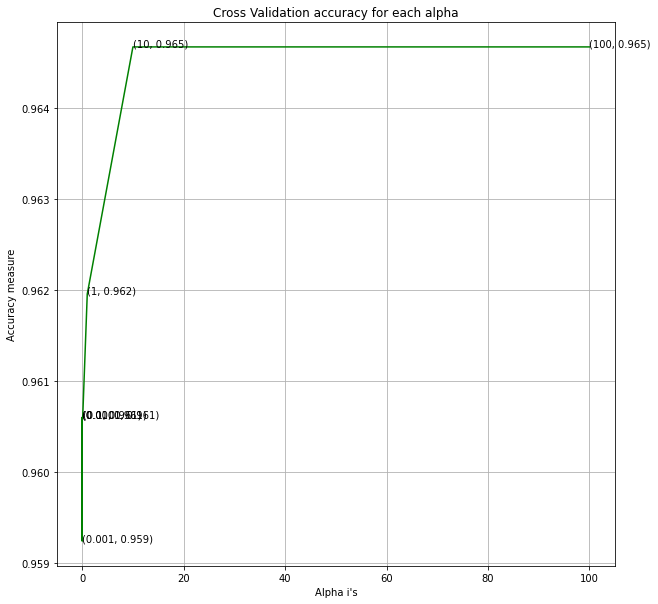

In [22]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

Accuracy on test data for final baseline model 0.9304347826086956
Precision on test data for final baseline model 0.9230769230769231
Recall on test data for final baseline model 0.9391304347826087
-------------------------------------------------- Confusion matrix --------------------------------------------------


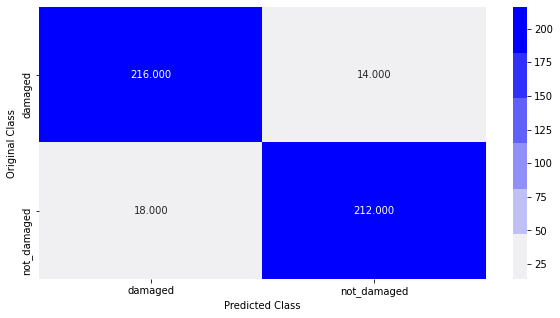

In [23]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'resnet/resnet_stage1_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
precision,recall = compute_precision_recall(y_test,predict_y)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_test,predict_y,stage1_class_labels)

In [24]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage1_baseline','Accuracy':'0.930','Precision':'0.923','Recall':'0.940'},ignore_index= True)

### Stage 2

In [25]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

In [27]:
train_feat,test_feat,train_fd,test_fd = model_features(model_resnet,train_data_dir, test_data_dir)

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [28]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [29]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [30]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

 14%|█▍        | 1/7 [01:12<07:16, 72.70s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 29%|██▊       | 2/7 [02:53<06:45, 81.13s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

Accuracy for alpha 0.0001 is  0.868020304568528
Accuracy for alpha 0.001 is  0.8781725888324873
Accuracy for alpha 0.01 is  0.883248730964467
Accuracy for alpha 0.1 is  0.8781725888324873
Accuracy for alpha 1 is  0.8807106598984772
Accuracy for alpha 10 is  0.8629441624365483
Accuracy for alpha 100 is  0.8629441624365483


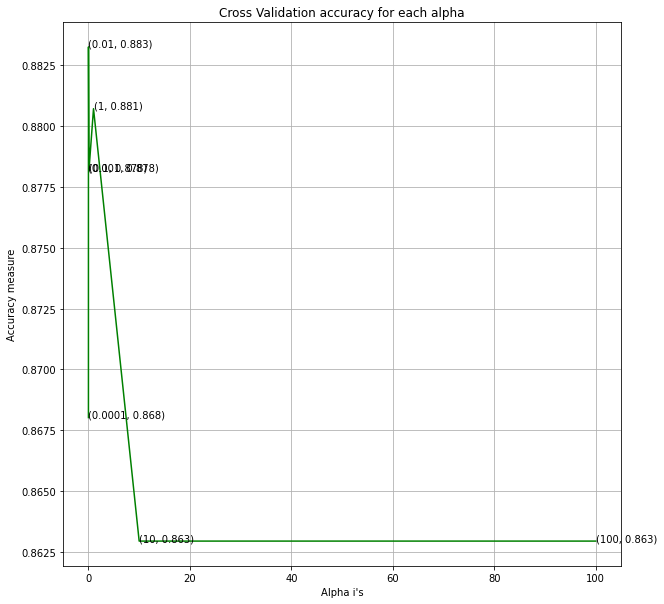

In [31]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy on test data for final baseline model 0.7821229050279329
Average Precision is 0.7915123456790122
Average Recall is 0.7792244003568992
-------------------------------------------------- Confusion Matrix --------------------------------------------------


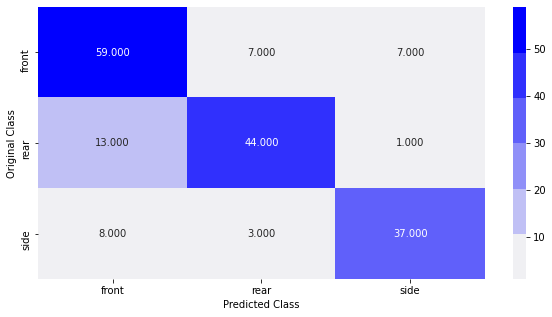

-------------------------------------------------- Precision Matrix --------------------------------------------------


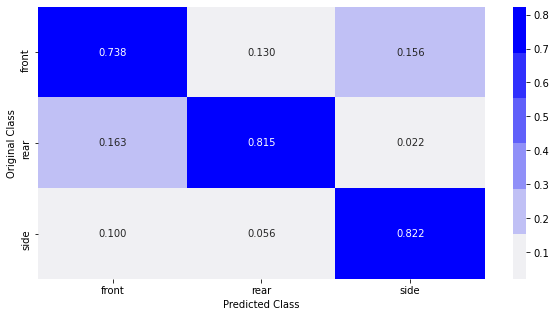

-------------------------------------------------- Recall Matrix --------------------------------------------------


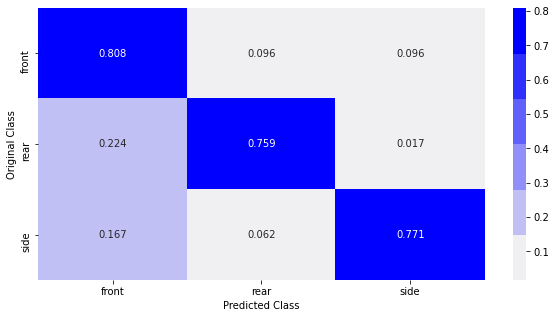

In [33]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model 
save_path = 'resnet/resnet_stage2_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage2_class_labels)

In [46]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage2_baseline','Accuracy':'0.782','Precision':'0.791','Recall':'0.779'},ignore_index= True)

### Stage 3

In [38]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

In [39]:
train_feat,test_feat,train_fd,test_fd = model_features(model_resnet,train_data_dir, test_data_dir)

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [40]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [41]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [42]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 14%|█▍        | 1/7 [01:41<10:07, 101.32s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Accuracy for alpha 0.0001 is  0.8163265306122449
Accuracy for alpha 0.001 is  0.8239795918367347
Accuracy for alpha 0.01 is  0.8290816326530612
Accuracy for alpha 0.1 is  0.8341836734693877
Accuracy for alpha 1 is  0.8341836734693877
Accuracy for alpha 10 is  0.8316326530612245
Accuracy for alpha 100 is  0.8341836734693877


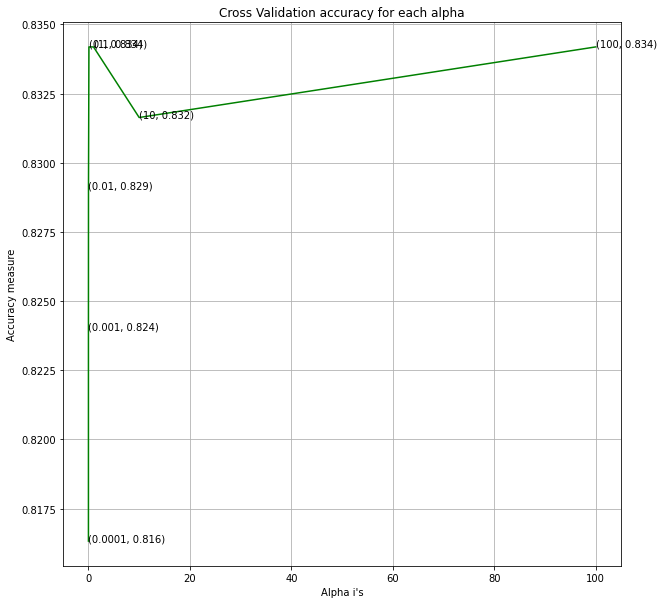

In [43]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy on test data for final baseline model 0.6374269005847953
Average Precision is 0.6331084120557805
Average Recall is 0.6207442067736185
-------------------------------------------------- Confusion Matrix --------------------------------------------------


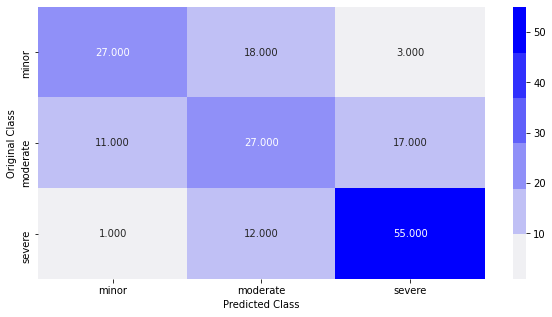

-------------------------------------------------- Precision Matrix --------------------------------------------------


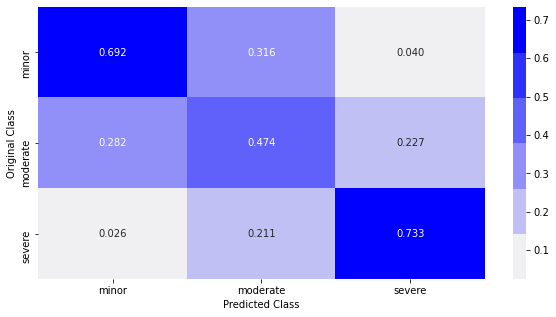

-------------------------------------------------- Recall Matrix --------------------------------------------------


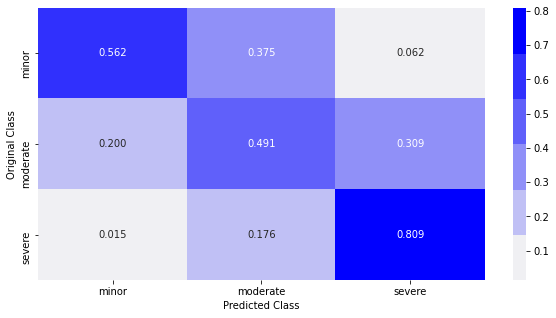

In [45]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'resnet/resnet_stage3_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage3_class_labels)

In [50]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage3_baseline','Accuracy':'0.637','Precision':'0.633','Recall':'0.621'},ignore_index= True)

### CNN (Training FC layers only)

In [51]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    resnet = applications.ResNet50(include_top=False,weights='imagenet',input_tensor = input_layer)
    resnet = non_trainable(resnet)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(resnet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [52]:
model = create_model(1,'sigmoid')

In [53]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [54]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

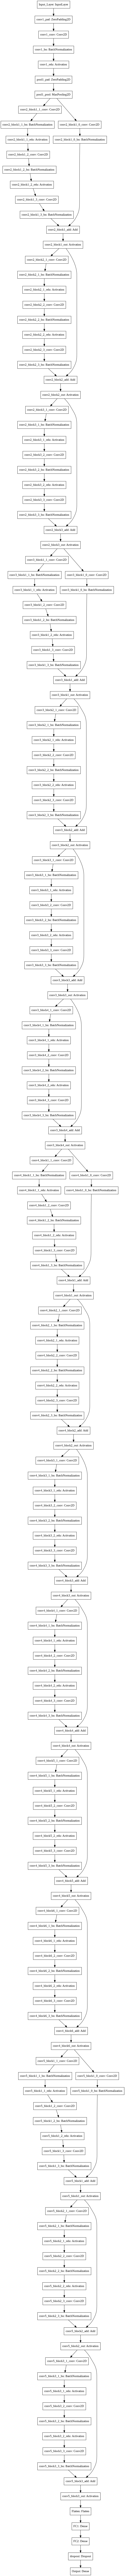

In [55]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [56]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage1_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [57]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [58]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [59]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
459/460 [============================>.] - ETA: 0s - loss: 0.4514 - accuracy: 0.8007
Epoch 00001: val_accuracy improved from -inf to 0.89565, saving model to resnet/resnet_stage1_fc-0.896.hdf5
460/460 [==============================] - 34s 74ms/step - loss: 0.4511 - accuracy: 0.8008 - val_loss: 0.2385 - val_accuracy: 0.8957
Epoch 2/50
459/460 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9202
Epoch 00002: val_accuracy improved from 0.89565 to 0.91087, saving model to resnet/resnet_stage1_fc-0.911.hdf5
460/460 [==============================] - 31s 68ms/step - loss: 0.2039 - accuracy: 0.9201 - val_loss: 0.2043 - val_accuracy: 0.9109
Epoch 3/50
459/460 [============================>.] - ETA: 0s - loss: 0.1315 - accuracy: 0.9515
Epoch 00003: val_accuracy improved from 0.91087 to 0.92609, saving model to resnet/resnet_stage1_fc-0.926.hdf5
460/460 [==============================] - 31s 68ms/step - loss: 0.1312 - accuracy: 0.9516 - val_loss: 0.1992 - val_

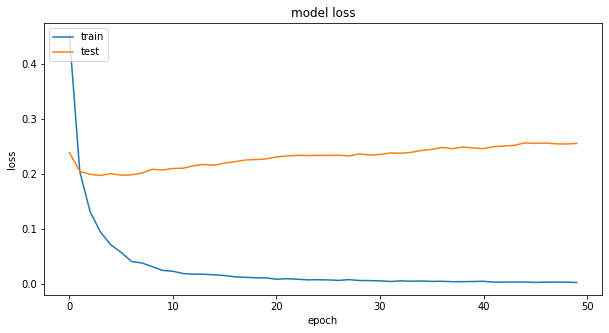

The loss for final model is  0.24686765670776367


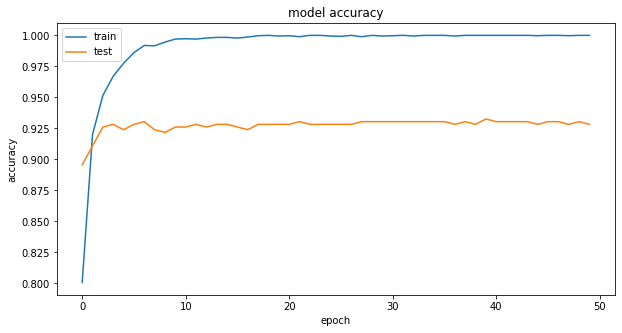

The accuracy for final model is  0.9326087236404419


In [60]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [61]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 460 images belonging to 2 classes.


In [62]:
best_model = load_model('resnet/resnet_stage1_fc-0.933.hdf5')

In [63]:
y_pred = best_model.predict(x_test)

In [64]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.9383259911894273
Recall on test data for final baseline model 0.9260869565217391
-------------------------------------------------- Confusion matrix --------------------------------------------------


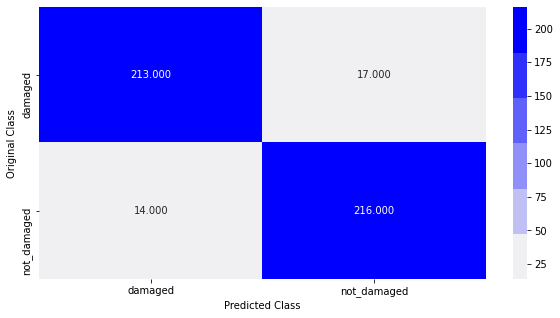

In [65]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [66]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage1 FC','Accuracy':'0.933','Precision':'0.938','Recall':'0.926'},ignore_index= True)

### Stage 2

In [67]:
model = create_model(3,'softmax')

In [68]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [69]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

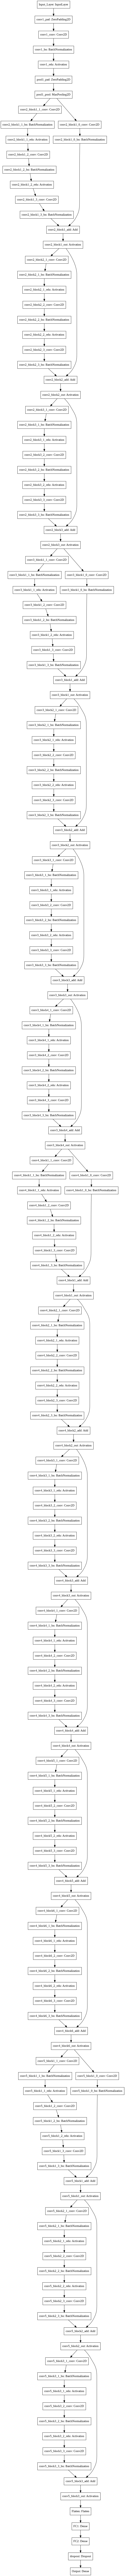

In [70]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [71]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage2_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [72]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [73]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [74]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
247/246 [==============================] - ETA: 0s - loss: 1.3316 - accuracy: 0.5005
Epoch 00001: val_accuracy improved from -inf to 0.61453, saving model to resnet/resnet_stage2_fc-0.615.hdf5
247/246 [==============================] - 16s 66ms/step - loss: 1.3316 - accuracy: 0.5005 - val_loss: 0.8469 - val_accuracy: 0.6145
Epoch 2/50
247/246 [==============================] - ETA: 0s - loss: 0.5315 - accuracy: 0.7792
Epoch 00002: val_accuracy improved from 0.61453 to 0.63687, saving model to resnet/resnet_stage2_fc-0.637.hdf5
247/246 [==============================] - 15s 62ms/step - loss: 0.5315 - accuracy: 0.7792 - val_loss: 0.8006 - val_accuracy: 0.6369
Epoch 3/50
246/246 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8838
Epoch 00003: val_accuracy improved from 0.63687 to 0.69274, saving model to resnet/resnet_stage2_fc-0.693.hdf5
247/246 [==============================] - 15s 61ms/step - loss: 0.3139 - accuracy: 0.8838 - val_loss: 0.7700 - val_

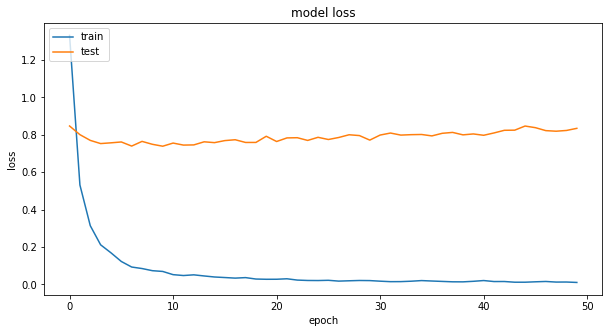

The loss for final model is  0.7579149007797241


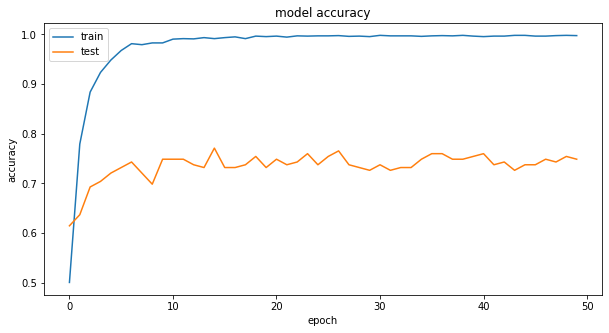

The accuracy for final model is  0.7709497213363647


In [75]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [76]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [79]:
best_model = load_model('resnet/resnet_stage2_fc-0.771.hdf5')

In [80]:
y_pred = best_model.predict(x_test)

In [81]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is 0.788558201058201
Average Recall is 0.7593817246627826
-------------------------------------------------- Confusion Matrix --------------------------------------------------


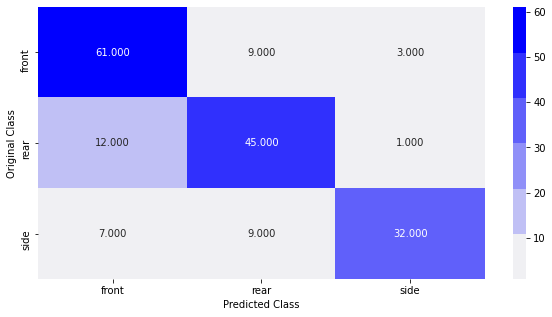

-------------------------------------------------- Precision Matrix --------------------------------------------------


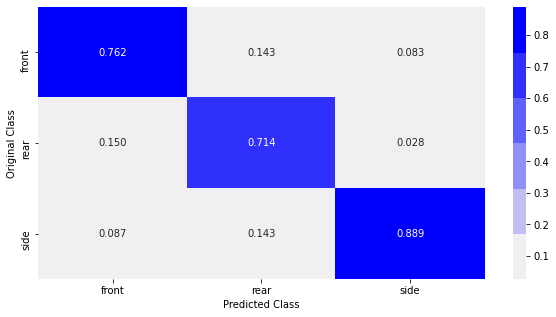

-------------------------------------------------- Recall Matrix --------------------------------------------------


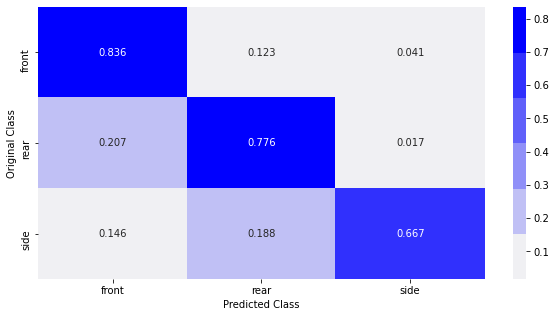

In [82]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [83]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage2 FC','Accuracy':'0.771','Precision':'0.788','Recall':'0.759'},ignore_index= True)

### Stage 3

In [84]:
model = create_model(3,'softmax')

In [85]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [86]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

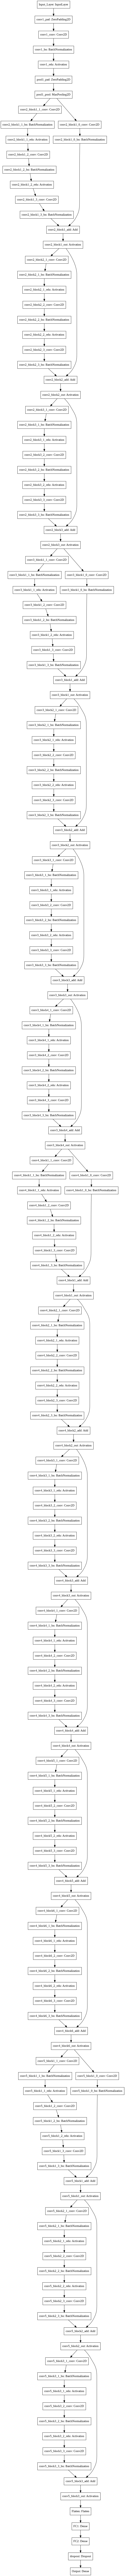

In [87]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [88]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage3_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [89]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [90]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [91]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
245/244 [==============================] - ETA: 0s - loss: 1.3227 - accuracy: 0.4990
Epoch 00001: val_accuracy improved from -inf to 0.57895, saving model to resnet/resnet_stage3_fc-0.579.hdf5
245/244 [==============================] - 16s 66ms/step - loss: 1.3227 - accuracy: 0.4990 - val_loss: 0.9008 - val_accuracy: 0.5789
Epoch 2/50
245/244 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.7630
Epoch 00002: val_accuracy improved from 0.57895 to 0.58480, saving model to resnet/resnet_stage3_fc-0.585.hdf5
245/244 [==============================] - 15s 62ms/step - loss: 0.5841 - accuracy: 0.7630 - val_loss: 0.8816 - val_accuracy: 0.5848
Epoch 3/50
244/244 [============================>.] - ETA: 0s - loss: 0.3556 - accuracy: 0.8615
Epoch 00003: val_accuracy improved from 0.58480 to 0.64327, saving model to resnet/resnet_stage3_fc-0.643.hdf5
245/244 [==============================] - 15s 62ms/step - loss: 0.3551 - accuracy: 0.8616 - val_loss: 0.8341 - val_

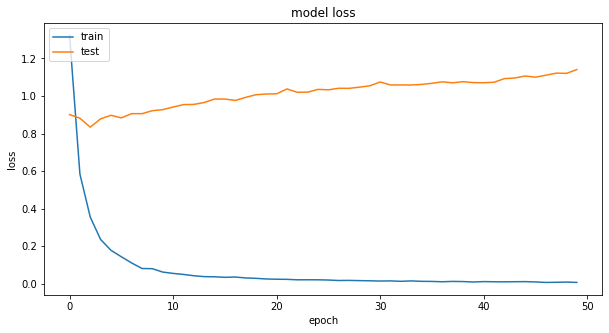

The loss for final model is  0.834102988243103


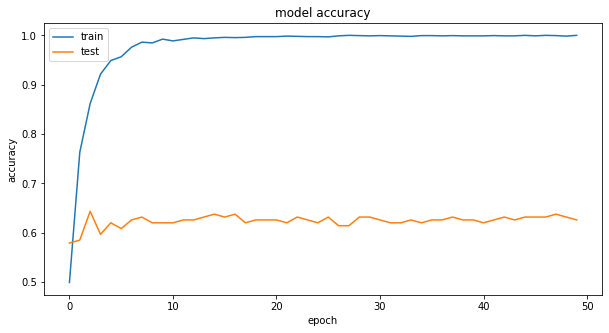

The accuracy for final model is  0.6432748436927795


In [92]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [93]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [94]:
best_model = load_model('resnet/resnet_stage3_fc-0.643.hdf5')

In [95]:
y_pred = best_model.predict(x_test)

In [96]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
    n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is 0.6277528928704741
Average Recall is 0.6303401663695781
-------------------------------------------------- Confusion Matrix --------------------------------------------------


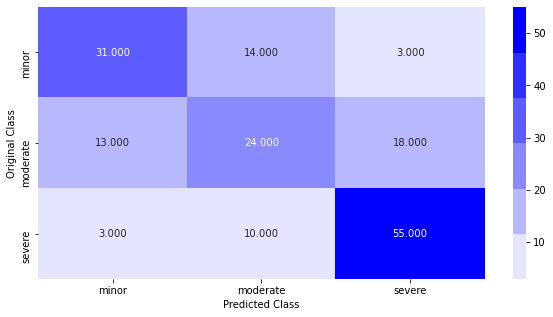

-------------------------------------------------- Precision Matrix --------------------------------------------------


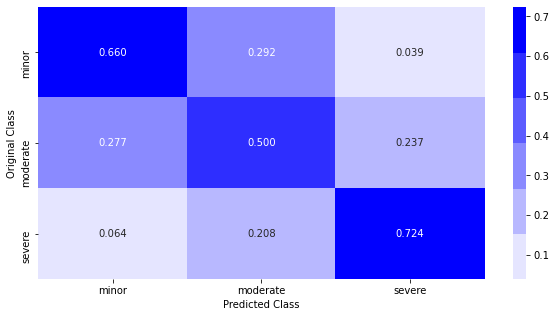

-------------------------------------------------- Recall Matrix --------------------------------------------------


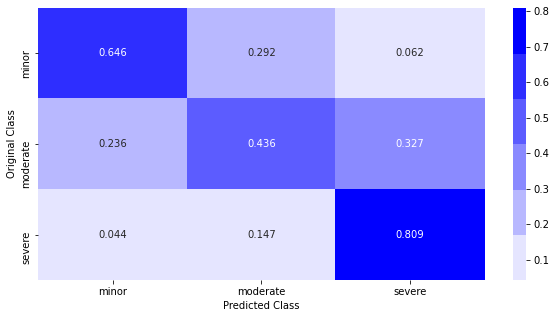

In [97]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [98]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage3 FC','Accuracy':'0.643','Precision':'0.628','Recall':'0.630'},ignore_index= True)

### CNN (Training All layers only)

In [104]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    resnet = applications.ResNet50(include_top=False,weights='imagenet',input_tensor = input_layer)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(resnet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [105]:
model = create_model(1,'sigmoid')

In [106]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [107]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

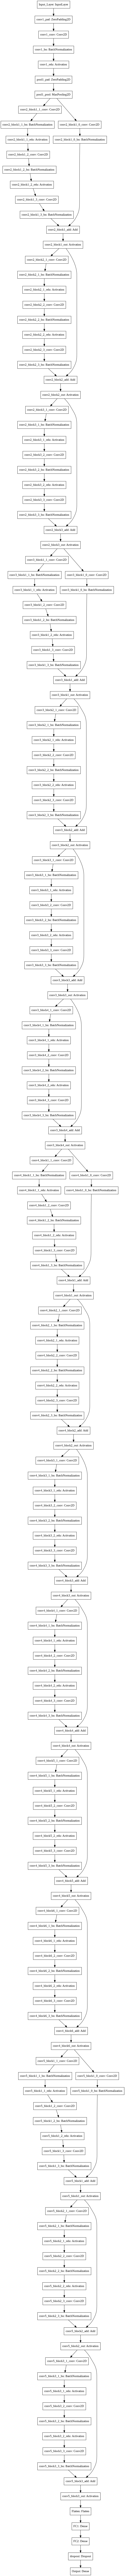

In [108]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [109]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage1_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [110]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [111]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [112]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
460/460 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.7995
Epoch 00001: val_accuracy improved from -inf to 0.91957, saving model to resnet/resnet_stage1_all-0.920.hdf5
460/460 [==============================] - 70s 153ms/step - loss: 0.4874 - accuracy: 0.7995 - val_loss: 0.2091 - val_accuracy: 0.9196
Epoch 2/50
460/460 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9008
Epoch 00002: val_accuracy improved from 0.91957 to 0.93043, saving model to resnet/resnet_stage1_all-0.930.hdf5
460/460 [==============================] - 69s 149ms/step - loss: 0.2398 - accuracy: 0.9008 - val_loss: 0.1788 - val_accuracy: 0.9304
Epoch 3/50
460/460 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.9321
Epoch 00003: val_accuracy improved from 0.93043 to 0.94130, saving model to resnet/resnet_stage1_all-0.941.hdf5
460/460 [==============================] - 69s 149ms/step - loss: 0.1667 - accuracy: 0.9321 - val_loss: 0.1614 

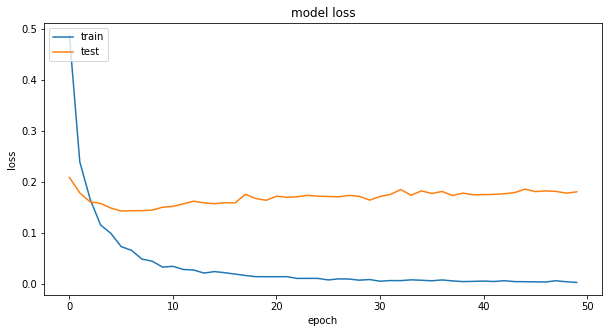

The loss for final model is  0.17370754480361938


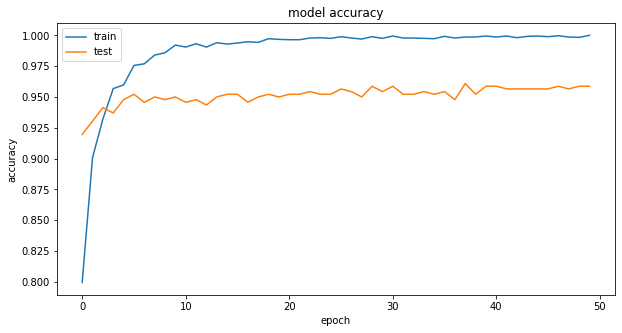

The accuracy for final model is  0.960869550704956


In [113]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [114]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 460 images belonging to 2 classes.


In [115]:
best_model = load_model('resnet/resnet_stage1_all-0.961.hdf5')

In [116]:
y_pred = best_model.predict(x_test)

In [117]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.9453781512605042
Recall on test data for final baseline model 0.9782608695652174
-------------------------------------------------- Confusion matrix --------------------------------------------------


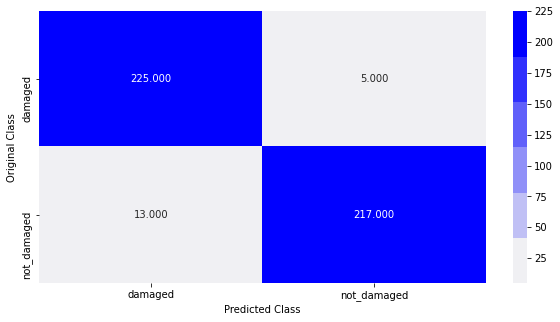

In [118]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [119]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage1 all','Accuracy':'0.961','Precision':'0.945','Recall':'0.978'},ignore_index= True)

### Stage 2

In [120]:
model = create_model(3,'softmax')

In [121]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [122]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

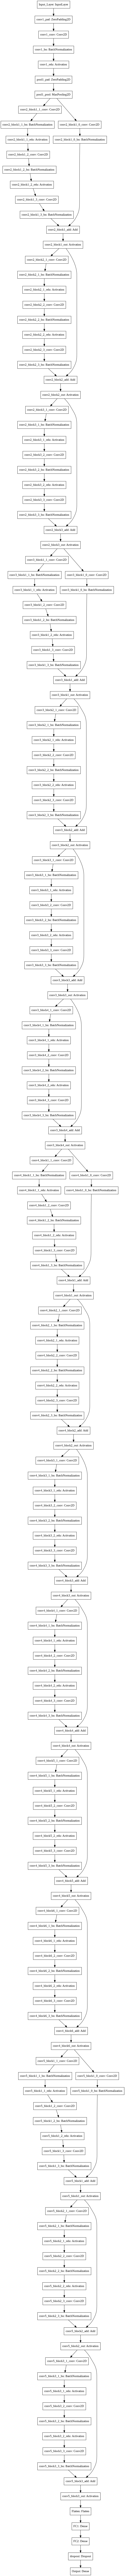

In [123]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [125]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage2_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [126]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [127]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [128]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
247/246 [==============================] - ETA: 0s - loss: 1.4569 - accuracy: 0.4563
Epoch 00001: val_accuracy improved from -inf to 0.60894, saving model to resnet/resnet_stage2_all-0.609.hdf5
247/246 [==============================] - 39s 156ms/step - loss: 1.4569 - accuracy: 0.4563 - val_loss: 0.8498 - val_accuracy: 0.6089
Epoch 2/50
247/246 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.6792
Epoch 00002: val_accuracy improved from 0.60894 to 0.67039, saving model to resnet/resnet_stage2_all-0.670.hdf5
247/246 [==============================] - 37s 150ms/step - loss: 0.7465 - accuracy: 0.6792 - val_loss: 0.7929 - val_accuracy: 0.6704
Epoch 3/50
247/246 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.7919
Epoch 00003: val_accuracy improved from 0.67039 to 0.67598, saving model to resnet/resnet_stage2_all-0.676.hdf5
247/246 [==============================] - 37s 151ms/step - loss: 0.5007 - accuracy: 0.7919 - val_loss: 0.7534 

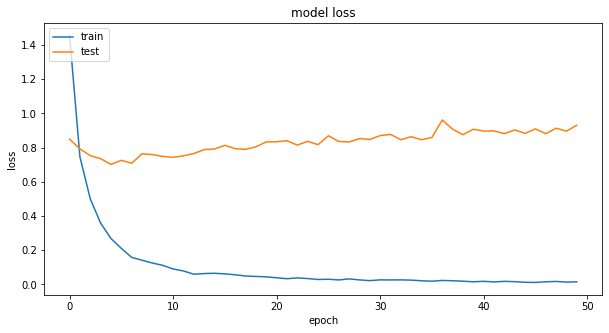

The loss for final model is  0.881771981716156


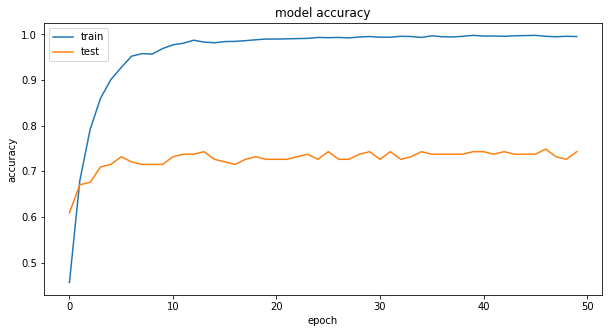

The accuracy for final model is  0.748603343963623


In [129]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [130]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [131]:
best_model = load_model('resnet/resnet_stage2_all-0.749.hdf5')

In [132]:
y_pred = best_model.predict(x_test)

In [133]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is 0.761545643898585
Average Recall is 0.7399687713221015
-------------------------------------------------- Confusion Matrix --------------------------------------------------


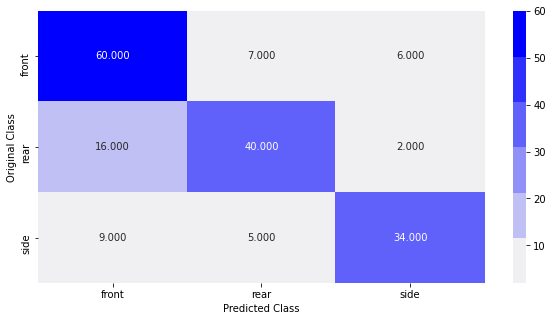

-------------------------------------------------- Precision Matrix --------------------------------------------------


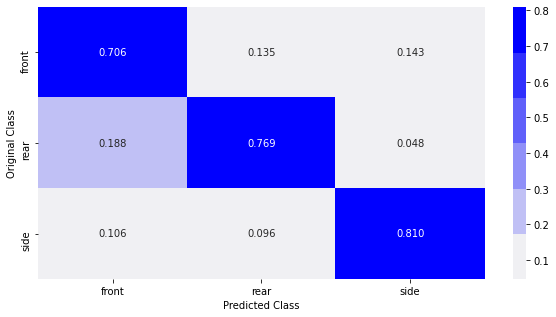

-------------------------------------------------- Recall Matrix --------------------------------------------------


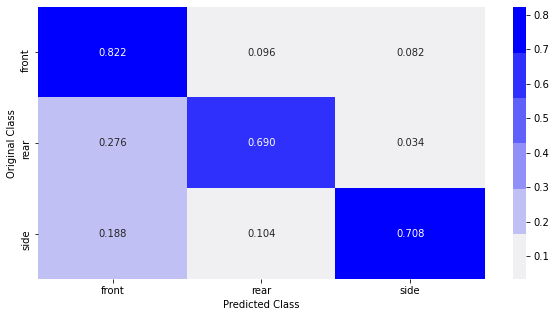

In [134]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [135]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage2 all','Accuracy':'0.749','Precision':'0.762','Recall':'0.740'},ignore_index= True)

### Stage 3

In [136]:
model = create_model(3,'softmax')

In [137]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [138]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

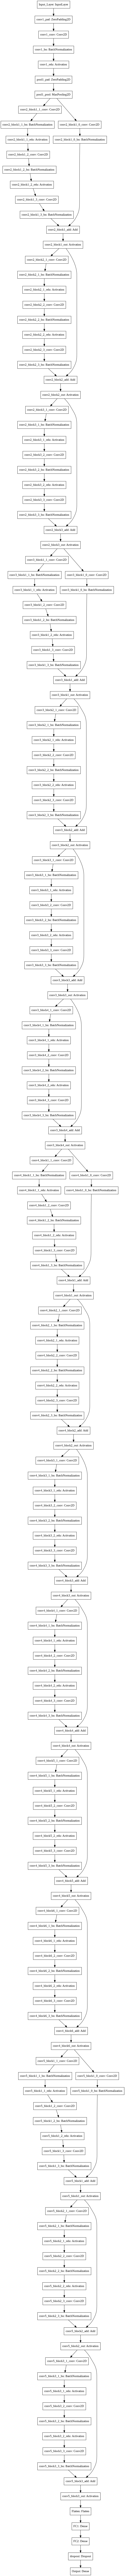

In [139]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [140]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage3_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [141]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [142]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [143]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=50,callbacks=[checkpoint])

Epoch 1/50
245/244 [==============================] - ETA: 0s - loss: 1.3841 - accuracy: 0.4653
Epoch 00001: val_accuracy improved from -inf to 0.52632, saving model to resnet/resnet_stage3_all-0.526.hdf5
245/244 [==============================] - 38s 156ms/step - loss: 1.3841 - accuracy: 0.4653 - val_loss: 1.0296 - val_accuracy: 0.5263
Epoch 2/50
245/244 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.6879
Epoch 00002: val_accuracy improved from 0.52632 to 0.57895, saving model to resnet/resnet_stage3_all-0.579.hdf5
245/244 [==============================] - 37s 152ms/step - loss: 0.7123 - accuracy: 0.6879 - val_loss: 0.9607 - val_accuracy: 0.5789
Epoch 3/50
245/244 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.7937
Epoch 00003: val_accuracy improved from 0.57895 to 0.60234, saving model to resnet/resnet_stage3_all-0.602.hdf5
245/244 [==============================] - 37s 151ms/step - loss: 0.5214 - accuracy: 0.7937 - val_loss: 0.9150 

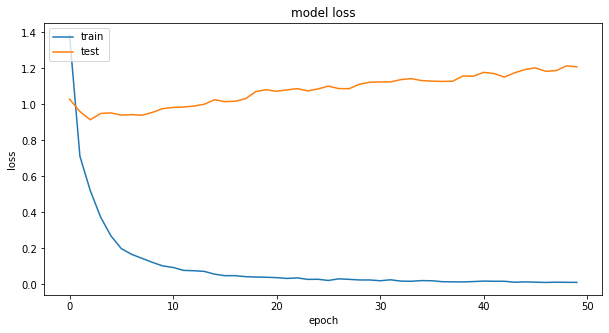

The loss for final model is  1.0883644819259644


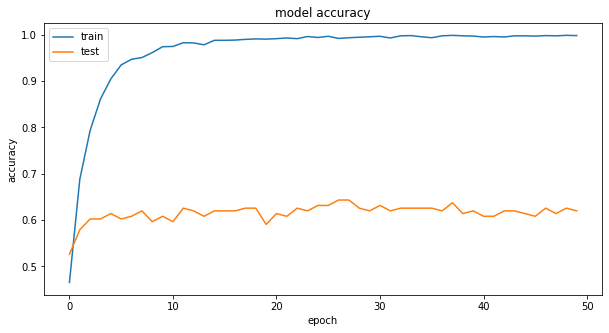

The accuracy for final model is  0.6432748436927795


In [144]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [147]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [148]:
best_model = load_model('resnet/resnet_stage3_all-0.643.hdf5')

In [149]:
y_pred = best_model.predict(x_test)

In [150]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is 0.6355305707757142
Average Recall is 0.6326574569221628
-------------------------------------------------- Confusion Matrix --------------------------------------------------


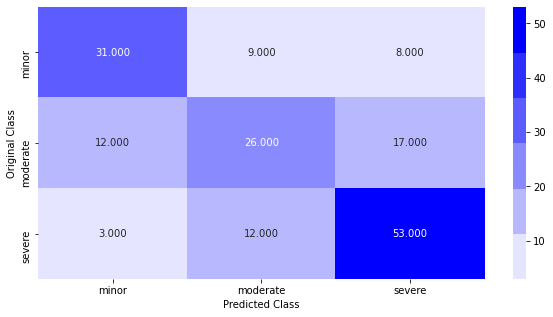

-------------------------------------------------- Precision Matrix --------------------------------------------------


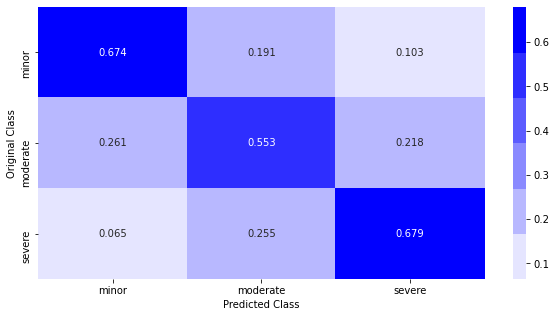

-------------------------------------------------- Recall Matrix --------------------------------------------------


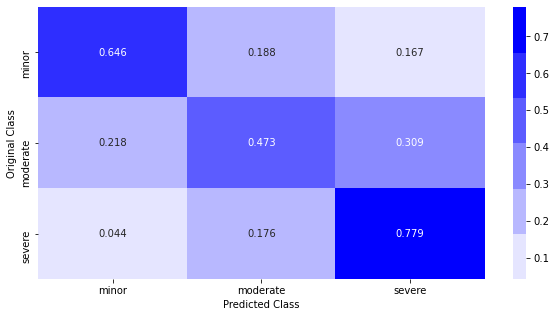

In [151]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [150]:
resnet_scores = resnet_scores.append({'Model':'Resnet_stage3 all','Accuracy':'0.643','Precision':'0.635','Recall':'0.633'},ignore_index= True)

In [151]:
resnet_scores.to_csv('resnet_scores.csv',index=False)